<a href="https://colab.research.google.com/github/jeanlucjackson/w266_final_project/blob/main/code/sandboxes/RR/rr_evaluation_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

In [8]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
from matplotlib import pyplot as plt

import scipy.stats as st

pd.set_option("precision", 5)
sns.set_theme()

In [10]:
evaluation_root = "/content/drive/MyDrive/w266 NLP Final Project/Evaluation/"
filename = evaluation_root + "evaluation_database.json"

evaluation_df = pd.read_json(filename)

In [11]:
evaluation_df.columns

Index(['prediction_set', 'base_model', 'trained_on', 'tested_on', 'nickname',
       'hyperparameter', 'target', 'prediction', 'bleu', 'rouge1', 'rouge2',
       'rougeL', 'rougeLsum', 'meteor', 'bertscore-precision',
       'bertscore-recall', 'bertscore-f1', 'bleurt', 'use'],
      dtype='object')

In [12]:
evaluation_exclusions = ["rouge1", "rouge2", "rougeLsum", "bertscore-precision", "bertscore-recall"]
evaluation_df = evaluation_df.drop(columns=evaluation_exclusions)

In [13]:
evaluation_metrics = evaluation_df.select_dtypes(exclude="object").columns
evaluation_metrics

Index(['bleu', 'rougeL', 'meteor', 'bertscore-f1', 'bleurt', 'use'], dtype='object')

In [51]:
# Apply this mask to remove all samples from non default inference sets
default_hyperparameter_mask = [sample['defaults'] for sample in evaluation_df.hyperparameter]

### BART vs T5



We built 5 BART models and 5 T5 models.

Each set of 5 models includes one model trained on each of our datasets plus one trained on all of our datasets.

We ran the validation sets from each of our datasets on each of our ten models yielding 40 sets of predictions.

#### In The Aggregate

We group the prediction sets by base model and calculate the mean for each metric.

In every case, the BART models outperform the T5 models.

We applied Welch's t-test to the metric distributions between the two models and, in each case, found $p$ values of less than .05 and reject the hypothesis that the distributions have equal means.

In [65]:
df = evaluation_df[default_hyperparameter_mask]
df.groupby(["base_model"]).mean()

,bleu,rougeL,meteor,bertscore-f1,bleurt,use
base_model,,,,,,
T5,0.0387,0.27841,0.25954,0.78287,-0.92718,0.46490
bart,0.0518,0.31417,0.29325,0.79770,-0.79155,0.51042


In [66]:
df_T5 = df[df["base_model"] == "T5"]
df_BART = df[df["base_model"] == "bart"]

In [67]:
bart_wins = 0
t5_wins = 0

print("BART wins the comparison except where noted otherwise\n")

for metric in evaluation_metrics:
    print(f"metric: {metric}", end=" ")
    T5 = df_T5[metric].mean()
    BART = df_BART[metric].mean()

    if BART > T5:
        print("")
        bart_wins += 1
    else:
        print("\t***T5 wins***")
        t5_wins += 1

print()
print(f"BART wins: {bart_wins} T5 wins: {t5_wins}")

BART wins the comparison except where noted otherwise

metric: bleu 
metric: rougeL 
metric: meteor 
metric: bertscore-f1 
metric: bleurt 
metric: use 

BART wins: 6 T5 wins: 0


In [68]:
reject_count = 0
fail_to_reject_count = 0

print("Reject the null hypothesis except where noted otherwise\n")

for metric in evaluation_metrics:

    p = st.ttest_ind(df_T5[metric], df_BART[metric], equal_var=False)[1]

    if p <= 0.05:
        reject_null = ""
        reject_count += 1
    else:
        reject_null = "***FAIL TO REJECT THE NULL***"
        fail_to_reject_count += 1

    print(f"metric: {metric} Welch's t-test p value {p}, {reject_null}")

print(
    f"\nreject the null: {reject_count}, fail to reject the null:  {fail_to_reject_count}"
)

Reject the null hypothesis except where noted otherwise

metric: bleu Welch's t-test p value 3.764658780054812e-119, 
metric: rougeL Welch's t-test p value 0.0, 
metric: meteor Welch's t-test p value 0.0, 
metric: bertscore-f1 Welch's t-test p value 0.0, 
metric: bleurt Welch's t-test p value 0.0, 
metric: use Welch's t-test p value 0.0, 

reject the null: 6, fail to reject the null:  0


#### Per Training Set

We group the prediction sets by base model and training set and calculate the mean for each metric.

In every case, the BART models outperform the T5 models.

We applied Welch's t-test to the metric distributions between the two models on each training set and metric, and, in all but one case, found $p$ values of less than .05 and reject the hypothesis that the distributions have equal means.

We are unable to reject the null hypothesis for the bertscore-F1 results on the T5 and BART models trained on the amalgamated dataset.


In [69]:
df = evaluation_df[default_hyperparameter_mask]
df = df.groupby(["trained_on", "base_model"]).mean()
df = df.reset_index()
df

,trained_on,base_model,bleu,rougeL,meteor,bertscore-f1,bleurt,use
0,amalgam,T5,0.08563,0.38169,0.37254,0.83105,-0.57658,0.58298
1,amalgam,bart,0.09873,0.38872,0.38606,0.83154,-0.56501,0.58404
2,nq,T5,0.02117,0.28921,0.22292,0.76594,-0.95578,0.49244
3,nq,bart,0.02499,0.29348,0.22864,0.76848,-0.92741,0.50252
4,quac,T5,0.00097,0.15093,0.12027,0.72844,-1.42809,0.26199
5,quac,bart,0.02474,0.26015,0.22003,0.78025,-0.95596,0.42917
6,squad,T5,0.05884,0.32965,0.31757,0.81023,-0.72394,0.52761
7,squad,bart,0.06580,0.33418,0.32219,0.81203,-0.71181,0.52881
8,triviaqa,T5,0.02687,0.24057,0.26442,0.77868,-0.95152,0.45950
9,triviaqa,bart,0.04471,0.29434,0.30931,0.79623,-0.79754,0.50756


In [70]:
bart_wins = 0
t5_wins = 0

print("BART wins the comparison except where noted otherwise\n")

for training_set in training_sets:
    for metric in evaluation_metrics:
        print(f"training set: {training_set}\tmetric: {metric}", end=" ")
        T5 = df[(df["base_model"] == "T5") & (df["trained_on"] == training_set)][
            metric
        ].values[0]
        BART = df[(df["base_model"] == "bart") & (df["trained_on"] == training_set)][
            metric
        ].values[0]

        if BART > T5:
            print("")
            bart_wins += 1
        else:
            print("\t***T5 wins***")
            t5_wins += 1

print()
print(f"BART wins = {bart_wins} T5 wins = {t5_wins}")

BART wins the comparison except where noted otherwise

training set: nq	metric: bleu 
training set: nq	metric: rougeL 
training set: nq	metric: meteor 
training set: nq	metric: bertscore-f1 
training set: nq	metric: bleurt 
training set: nq	metric: use 
training set: triviaqa	metric: bleu 
training set: triviaqa	metric: rougeL 
training set: triviaqa	metric: meteor 
training set: triviaqa	metric: bertscore-f1 
training set: triviaqa	metric: bleurt 
training set: triviaqa	metric: use 
training set: squad	metric: bleu 
training set: squad	metric: rougeL 
training set: squad	metric: meteor 
training set: squad	metric: bertscore-f1 
training set: squad	metric: bleurt 
training set: squad	metric: use 
training set: quac	metric: bleu 
training set: quac	metric: rougeL 
training set: quac	metric: meteor 
training set: quac	metric: bertscore-f1 
training set: quac	metric: bleurt 
training set: quac	metric: use 
training set: amalgam	metric: bleu 
training set: amalgam	metric: rougeL 
training 

In [71]:
reject_count = 0
fail_to_reject_count = 0

print("Reject the null hypothesis except where noted otherwise\n")

for training_set in training_sets:
    T5_set = df_T5[df_T5["trained_on"] == training_set]
    BART_set = df_BART[df_BART["trained_on"] == training_set]

    for metric in evaluation_metrics:
        p = st.ttest_ind(T5_set[metric], BART_set[metric], equal_var=False)[1]
        if p <= 0.05:
            reject_null = ""
            reject_count += 1
        else:
            reject_null = "***FAIL TO REJECT THE NULL"
            fail_to_reject_count += 1

        print(
            f"training set: {training_set} metric: {metric} p value: {p}, {reject_null}"
        )

print(
    f"\nreject the null: {reject_count}, fail to reject the null:  {fail_to_reject_count}"
)

Reject the null hypothesis except where noted otherwise

training set: nq metric: bleu p value: 1.992906597378803e-05, 
training set: nq metric: rougeL p value: 0.014497692035772832, 
training set: nq metric: meteor p value: 0.0007313322173923156, 
training set: nq metric: bertscore-f1 p value: 3.185362341150022e-05, 
training set: nq metric: bleurt p value: 2.978969780151862e-10, 
training set: nq metric: use p value: 2.6044499368858534e-08, 
training set: triviaqa metric: bleu p value: 3.097044394772555e-71, 
training set: triviaqa metric: rougeL p value: 2.8278862414229315e-229, 
training set: triviaqa metric: meteor p value: 1.4343362459542718e-149, 
training set: triviaqa metric: bertscore-f1 p value: 8.025047834874147e-172, 
training set: triviaqa metric: bleurt p value: 8.675016634369094e-267, 
training set: triviaqa metric: use p value: 5.685535596964075e-136, 
training set: squad metric: bleu p value: 2.670640503512896e-06, 
training set: squad metric: rougeL p value: 0.021409

### Which Model Is Best?

We have already concluded that our BART models outperform our T5 models.

Next we look at each of our models to see which performs the best when we consider every inference made with that model.  We consider each of our evaluation metrics.

The top 5 models, regardless of the metric used are

1. BART trained on the amalgamated set 
2. T5 trained on the amalgamated set 
3. BART trained on SQuAD 
4. T5 trained on SQuAD 
5. BART trained on TriviaQA 

### Beam search and no repeat ngrams on TriviaQA



We ran the full suite of inference tests on our BART models with beam search and the use of a no repeat ngram parameters.  The primnary motivation for this experiment was to see if we would get better performance on the TriviaQA validation set.  As shown below, our top performance on each metric we consider remains the model trained on the amalgamated dataset and running inference without beam search or the use of a no repeat ngram parameter.

In [63]:
df_BART = evaluation_df[evaluation_df["base_model"] == "bart"]

In [64]:
for metric in evaluation_metrics:
  df=df_BART[['nickname', 'trained_on', 'tested_on', metric]]
  df=df[df.tested_on=='triviaqa']
  display(df.groupby(['nickname', 'trained_on', 'tested_on']).mean().sort_values([metric], ascending=False)[:4])

,,,bleu
nickname,trained_on,tested_on,
bart_amalgam_triviaqa,amalgam,triviaqa,0.07797
bart_amalgam_triviaqa_hyp,amalgam,triviaqa,0.07770
bart_triviaqa_triviaqa_hyp,triviaqa,triviaqa,0.07725
bart_triviaqa_triviaqa,triviaqa,triviaqa,0.07601


,,,rougeL
nickname,trained_on,tested_on,
bart_amalgam_triviaqa,amalgam,triviaqa,0.36872
bart_triviaqa_triviaqa_hyp,triviaqa,triviaqa,0.36863
bart_amalgam_triviaqa_hyp,amalgam,triviaqa,0.36817
bart_triviaqa_triviaqa,triviaqa,triviaqa,0.36778


,,,meteor
nickname,trained_on,tested_on,
bart_amalgam_triviaqa,amalgam,triviaqa,0.35459
bart_amalgam_triviaqa_hyp,amalgam,triviaqa,0.35355
bart_triviaqa_triviaqa_hyp,triviaqa,triviaqa,0.35157
bart_triviaqa_triviaqa,triviaqa,triviaqa,0.35103


,,,bertscore-f1
nickname,trained_on,tested_on,
bart_amalgam_triviaqa,amalgam,triviaqa,0.82643
bart_amalgam_triviaqa_hyp,amalgam,triviaqa,0.82634
bart_triviaqa_triviaqa_hyp,triviaqa,triviaqa,0.82595
bart_triviaqa_triviaqa,triviaqa,triviaqa,0.82592


,,,bleurt
nickname,trained_on,tested_on,
bart_amalgam_triviaqa,amalgam,triviaqa,-0.62649
bart_amalgam_triviaqa_hyp,amalgam,triviaqa,-0.62791
bart_triviaqa_triviaqa,triviaqa,triviaqa,-0.63144
bart_triviaqa_triviaqa_hyp,triviaqa,triviaqa,-0.63201


,,,use
nickname,trained_on,tested_on,
bart_amalgam_triviaqa,amalgam,triviaqa,0.60919
bart_amalgam_triviaqa_hyp,amalgam,triviaqa,0.60836
bart_triviaqa_triviaqa_hyp,triviaqa,triviaqa,0.60810
bart_triviaqa_triviaqa,triviaqa,triviaqa,0.60780


### Kendall's Tau

In [114]:
df = evaluation_df[default_hyperparameter_mask]
baseline = (
    df[
        (df["base_model"] == "T5")
        & (df["trained_on"] == "squad")
        & (df["tested_on"] == "squad")
    ]
    .groupby(["base_model", "trained_on", "tested_on"])
    .mean()
)
baseline

,,,bleu,rougeL,meteor,bertscore-f1,bleurt,use
base_model,trained_on,tested_on,,,,,,
T5,squad,squad,0.13233,0.45207,0.4555,0.86493,-0.31867,0.64221


In [109]:
nq_df = (
    df[df["tested_on"] == "nq"]
    .groupby(["base_model", "trained_on", "tested_on"])
    .mean()
    .sort_values(by=["bertscore-f1"], ascending=False)
)

nq_df

bleu   rougeL   meteor  bertscore-f1  \
base_model trained_on tested_on                                            
bart       nq         nq         0.20307  0.55043  0.52880       0.86740   
           amalgam    nq         0.19669  0.54500  0.52354       0.86433   
T5         nq         nq         0.16104  0.51909  0.49161       0.85663   
           amalgam    nq         0.16134  0.52017  0.49404       0.85637   
bart       squad      nq         0.01179  0.41060  0.35530       0.79860   
T5         squad      nq         0.01195  0.40648  0.35192       0.79641   
bart       triviaqa   nq         0.01142  0.36562  0.36744       0.79559   
T5         triviaqa   nq         0.00580  0.27229  0.29164       0.77015   
bart       quac       nq         0.00504  0.32612  0.22437       0.75054   
T5         quac       nq         0.00015  0.14482  0.07611       0.68803   

                                  bleurt      use  
base_model trained_on tested_on                    
bart       nq         nq        -0.25072  0.73665  
           amalgam    nq        -0.26720  0.72929  
T5         nq         nq        -0.36865  0.71261  
           amalgam    nq        -0.35621  0.71419  
bart       squad      nq        -0.63291  0.63030  
T5         squad      nq        -0.66086  0.62693  
bart       triviaqa   nq        -0.73634  0.62305  
T5         triviaqa   nq        -0.94372  0.54324  
bart       quac       nq        -0.99088  0.51657  
T5         quac       nq        -1.50722  0.28838

In [110]:
quac_df = (
    df[df["tested_on"] == "quac"]
    .groupby(["base_model", "trained_on", "tested_on"])
    .mean()
    .sort_values(by=["bertscore-f1"], ascending=False)
)

quac_df

bleu   rougeL   meteor  bertscore-f1  \
base_model trained_on tested_on                                            
bart       quac       quac       0.05722  0.28275  0.28805       0.79280   
T5         amalgam    quac       0.02904  0.25220  0.25508       0.78506   
bart       amalgam    quac       0.02741  0.23367  0.25015       0.77052   
T5         quac       quac       0.00260  0.17103  0.16533       0.76010   
           squad      quac       0.00619  0.18373  0.20958       0.75426   
bart       squad      quac       0.00712  0.18418  0.20587       0.75398   
           triviaqa   quac       0.00146  0.11367  0.16401       0.70975   
T5         triviaqa   quac       0.00097  0.09891  0.14970       0.70734   
bart       nq         quac       0.00108  0.14961  0.11261       0.69718   
T5         nq         quac       0.00100  0.15030  0.11132       0.69640   

                                  bleurt      use  
base_model trained_on tested_on                    
bart       quac       quac      -0.80825  0.41877  
T5         amalgam    quac      -0.93554  0.39845  
bart       amalgam    quac      -1.04438  0.36381  
T5         quac       quac      -1.37046  0.32111  
           squad      quac      -1.15841  0.32318  
bart       squad      quac      -1.21476  0.31848  
           triviaqa   quac      -1.37454  0.24343  
T5         triviaqa   quac      -1.38607  0.22709  
bart       nq         quac      -1.34135  0.28656  
T5         nq         quac      -1.36087  0.28539

In [111]:
squad_df = (
    df[df["tested_on"] == "squad"]
    .groupby(["base_model", "trained_on", "tested_on"])
    .mean()
    .sort_values(by=["bertscore-f1"], ascending=False)
)

squad_df

bleu   rougeL   meteor  bertscore-f1  \
base_model trained_on tested_on                                            
bart       squad      squad      0.15124  0.46919  0.47534       0.86954   
T5         squad      squad      0.13233  0.45207  0.45550       0.86493   
bart       amalgam    squad      0.13581  0.45858  0.46014       0.86285   
T5         amalgam    squad      0.12522  0.45517  0.45304       0.86205   
bart       triviaqa   squad      0.04703  0.31041  0.33821       0.81675   
           quac       squad      0.02772  0.29090  0.24561       0.80295   
T5         triviaqa   squad      0.02849  0.24260  0.28936       0.79096   
           nq         squad      0.01408  0.33007  0.25932       0.78627   
bart       nq         squad      0.01439  0.32262  0.25203       0.78382   
T5         quac       squad      0.00094  0.17344  0.13432       0.74166   

                                  bleurt      use  
base_model trained_on tested_on                    
bart       squad      squad     -0.26694  0.65707  
T5         squad      squad     -0.31867  0.64221  
bart       amalgam    squad     -0.30807  0.65053  
T5         amalgam    squad     -0.32648  0.64673  
bart       triviaqa   squad     -0.64540  0.53518  
           quac       squad     -0.83182  0.44558  
T5         triviaqa   squad     -0.87923  0.45805  
           nq         squad     -0.76260  0.53970  
bart       nq         squad     -0.76472  0.54066  
T5         quac       squad     -1.35503  0.25711

In [112]:
triviaqa_df = (
    df[df["tested_on"] == "triviaqa"]
    .groupby(["base_model", "trained_on", "tested_on"])
    .mean()
    .sort_values(by=["bertscore-f1"], ascending=False)
)

triviaqa_df

bleu   rougeL   meteor  bertscore-f1  \
base_model trained_on tested_on                                            
bart       amalgam    triviaqa   0.07797  0.36872  0.35459       0.82643   
           triviaqa   triviaqa   0.07601  0.36778  0.35103       0.82592   
T5         amalgam    triviaqa   0.05869  0.34681  0.32700       0.81911   
           triviaqa   triviaqa   0.04561  0.31530  0.29953       0.81009   
           squad      triviaqa   0.02251  0.26675  0.22553       0.78815   
bart       squad      triviaqa   0.02193  0.26027  0.21907       0.78809   
           nq         triviaqa   0.00800  0.28644  0.20083       0.77083   
T5         nq         triviaqa   0.00732  0.27312  0.18601       0.76386   
bart       quac       triviaqa   0.00687  0.19781  0.15091       0.75547   
T5         quac       triviaqa   0.00024  0.11620  0.08886       0.70503   

                                  bleurt      use  
base_model trained_on tested_on                    
bart       amalgam    triviaqa  -0.62649  0.60919  
           triviaqa   triviaqa  -0.63144  0.60780  
T5         amalgam    triviaqa  -0.68398  0.59314  
           triviaqa   triviaqa  -0.77181  0.57968  
           squad      triviaqa  -0.91539  0.50262  
bart       squad      triviaqa  -0.90873  0.49215  
           nq         triviaqa  -1.01739  0.53430  
T5         nq         triviaqa  -1.06236  0.51245  
bart       quac       triviaqa  -1.16915  0.39679  
T5         quac       triviaqa  -1.52205  0.22563

In [113]:
metrics = list(squad_df.columns)
datasets = df["tested_on"].unique()
print(f"metrics = {metrics} \ndatasets = {datasets}")

metrics = ['bleu', 'rougeL', 'meteor', 'bertscore-f1', 'bleurt', 'use'] 
datasets = ['nq' 'squad' 'quac' 'triviaqa']


In [116]:
# We gather the predictions for a validation dataset
# Sort the rows from best to worst scores on one metric
# Then we build ranking vectors for all metrics

rankings = {}

for dataset in datasets:
    slice_df = (
        df[df["tested_on"] == dataset]
        .groupby(["base_model", "trained_on", "tested_on"])
        .mean()
        .sort_values(by=["bleu"], ascending=False)
    )
    for metric in metrics:
        vector = [sorted(slice_df[metric], reverse=True).index(x) + 1 for x in slice_df[metric]]
        rankings[(dataset, metric)] = vector

In [117]:
rankings

{('nq', 'bleu'): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 ('nq', 'rougeL'): [1, 2, 3, 4, 6, 5, 7, 9, 8, 10],
 ('nq', 'meteor'): [1, 2, 3, 4, 7, 6, 5, 8, 9, 10],
 ('nq', 'bertscore-f1'): [1, 2, 4, 3, 6, 5, 7, 8, 9, 10],
 ('nq', 'bleurt'): [1, 2, 3, 4, 6, 5, 7, 8, 9, 10],
 ('nq', 'use'): [1, 2, 3, 4, 6, 5, 7, 8, 9, 10],
 ('squad', 'bleu'): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 ('squad', 'rougeL'): [1, 2, 4, 3, 7, 9, 8, 6, 5, 10],
 ('squad', 'meteor'): [1, 2, 3, 4, 5, 6, 9, 8, 7, 10],
 ('squad', 'bertscore-f1'): [1, 3, 2, 4, 5, 7, 6, 9, 8, 10],
 ('squad', 'bleurt'): [1, 2, 3, 4, 5, 9, 8, 7, 6, 10],
 ('squad', 'use'): [1, 2, 4, 3, 7, 8, 9, 5, 6, 10],
 ('quac', 'bleu'): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 ('quac', 'rougeL'): [1, 2, 3, 4, 5, 6, 9, 8, 7, 10],
 ('quac', 'meteor'): [1, 2, 3, 5, 4, 6, 7, 9, 10, 8],
 ('quac', 'bertscore-f1'): [1, 2, 3, 6, 5, 4, 7, 9, 10, 8],
 ('quac', 'bleurt'): [1, 2, 3, 5, 4, 8, 9, 6, 7, 10],
 ('quac', 'use'): [1, 2, 3, 6, 4, 5, 9, 7, 8, 10],
 ('triviaqa', 'bleu'): [1, 2, 3

In [118]:
vectors = {}
for dataset in datasets:
    vectors[dataset] = {metric: rankings[(dataset, metric)] for metric in metrics}
vectors

{'nq': {'bleu': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  'rougeL': [1, 2, 3, 4, 6, 5, 7, 9, 8, 10],
  'meteor': [1, 2, 3, 4, 7, 6, 5, 8, 9, 10],
  'bertscore-f1': [1, 2, 4, 3, 6, 5, 7, 8, 9, 10],
  'bleurt': [1, 2, 3, 4, 6, 5, 7, 8, 9, 10],
  'use': [1, 2, 3, 4, 6, 5, 7, 8, 9, 10]},
 'squad': {'bleu': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  'rougeL': [1, 2, 4, 3, 7, 9, 8, 6, 5, 10],
  'meteor': [1, 2, 3, 4, 5, 6, 9, 8, 7, 10],
  'bertscore-f1': [1, 3, 2, 4, 5, 7, 6, 9, 8, 10],
  'bleurt': [1, 2, 3, 4, 5, 9, 8, 7, 6, 10],
  'use': [1, 2, 4, 3, 7, 8, 9, 5, 6, 10]},
 'quac': {'bleu': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  'rougeL': [1, 2, 3, 4, 5, 6, 9, 8, 7, 10],
  'meteor': [1, 2, 3, 5, 4, 6, 7, 9, 10, 8],
  'bertscore-f1': [1, 2, 3, 6, 5, 4, 7, 9, 10, 8],
  'bleurt': [1, 2, 3, 5, 4, 8, 9, 6, 7, 10],
  'use': [1, 2, 3, 6, 4, 5, 9, 7, 8, 10]},
 'triviaqa': {'bleu': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  'rougeL': [1, 2, 3, 4, 7, 8, 5, 6, 9, 10],
  'meteor': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  'bertscore-f1'

In [119]:
ranking_df = {dataset: pd.DataFrame(vectors[dataset]) for dataset in datasets}
for k, v in ranking_df.items():
    print(k)
    print(v)

nq
   bleu  rougeL  meteor  bertscore-f1  bleurt  use
0     1       1       1             1       1    1
1     2       2       2             2       2    2
2     3       3       3             4       3    3
3     4       4       4             3       4    4
4     5       6       7             6       6    6
5     6       5       6             5       5    5
6     7       7       5             7       7    7
7     8       9       8             8       8    8
8     9       8       9             9       9    9
9    10      10      10            10      10   10
squad
   bleu  rougeL  meteor  bertscore-f1  bleurt  use
0     1       1       1             1       1    1
1     2       2       2             3       2    2
2     3       4       3             2       3    4
3     4       3       4             4       4    3
4     5       7       5             5       5    7
5     6       9       6             7       9    8
6     7       8       9             6       8    9
7     8       6       

In [120]:
kendall_df = {
    dataset: ranking_df[dataset].corr(method="kendall") for dataset in datasets
}
for k, v in kendall_df.items():
    print(k)
    print(v)

nq
                 bleu   rougeL   meteor  bertscore-f1   bleurt      use
bleu          1.00000  0.91111  0.86667       0.91111  0.95556  0.95556
rougeL        0.91111  1.00000  0.86667       0.91111  0.95556  0.95556
meteor        0.86667  0.86667  1.00000       0.86667  0.91111  0.91111
bertscore-f1  0.91111  0.91111  0.86667       1.00000  0.95556  0.95556
bleurt        0.95556  0.95556  0.91111       0.95556  1.00000  1.00000
use           0.95556  0.95556  0.91111       0.95556  1.00000  1.00000
squad
                 bleu   rougeL   meteor  bertscore-f1   bleurt      use
bleu          1.00000  0.60000  0.86667       0.86667  0.73333  0.68889
rougeL        0.60000  1.00000  0.73333       0.64444  0.86667  0.91111
meteor        0.86667  0.73333  1.00000       0.82222  0.86667  0.73333
bertscore-f1  0.86667  0.64444  0.82222       1.00000  0.77778  0.55556
bleurt        0.73333  0.86667  0.86667       0.77778  1.00000  0.77778
use           0.68889  0.91111  0.73333       0.55556  

In [121]:
# It does not matter which set we use to build the mask
mask = np.triu(np.ones_like(kendall_df["squad"].corr(), dtype=bool))
mask

array([[ True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True],
       [False, False, False, False,  True,  True],
       [False, False, False, False, False,  True]])

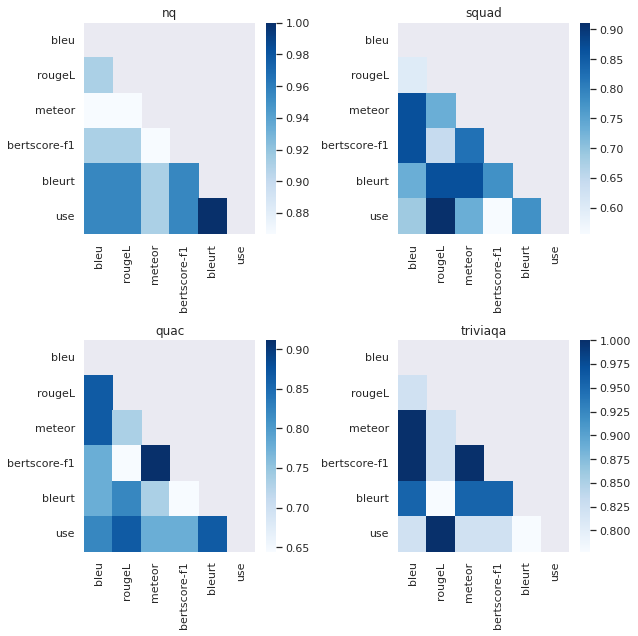

In [122]:
fig, axes = plt.subplots(2, 2, figsize=(9, 9))

for ax, dataset in zip(axes.flat, datasets):
    sns.heatmap(kendall_df[dataset], mask=mask, cmap="Blues", ax=ax).set(title=dataset)

fig.tight_layout()

plt.show()

### Cosine Similarity

In [123]:
vectors = {}
for dataset in datasets:
    vectors[dataset] = [rankings[(dataset, metric)] for metric in metrics]

In [124]:
similarity = {}
for dataset in datasets:
    similarity[dataset] = pd.DataFrame(
        cosine_similarity(vectors[dataset]), columns=metrics, index=metrics
    )

In [ ]:
similarity["nq"]

,bleu,rougeL,meteor,bleurt,bertscore-f1
bleu,1.00000,0.99481,0.98961,0.99740,0.99481
rougeL,0.99481,1.00000,0.98961,0.99740,0.99481
meteor,0.98961,0.98961,1.00000,0.99221,0.98961
bleurt,0.99740,0.99740,0.99221,1.00000,0.99740
bertscore-f1,0.99481,0.99481,0.98961,0.99740,1.00000


In [125]:
similarity["quac"]

,bleu,rougeL,meteor,bertscore-f1,bleurt,use
bleu,1.00000,0.98961,0.98961,0.98182,0.97662,0.98442
rougeL,0.98961,1.00000,0.97403,0.96623,0.98701,0.98961
meteor,0.98961,0.97403,1.00000,0.99221,0.96104,0.97662
bertscore-f1,0.98182,0.96623,0.99221,1.00000,0.94286,0.97662
bleurt,0.97662,0.98701,0.96104,0.94286,1.00000,0.98442
use,0.98442,0.98961,0.97662,0.97662,0.98442,1.00000


In [126]:
similarity["squad"]

,bleu,rougeL,meteor,bertscore-f1,bleurt,use
bleu,1.00000,0.95325,0.98961,0.99221,0.97403,0.95844
rougeL,0.95325,1.00000,0.96883,0.95325,0.98961,0.99481
meteor,0.98961,0.96883,1.00000,0.98182,0.98442,0.97403
bertscore-f1,0.99221,0.95325,0.98182,1.00000,0.97662,0.94805
bleurt,0.97403,0.98961,0.98442,0.97662,1.00000,0.98442
use,0.95844,0.99481,0.97403,0.94805,0.98442,1.00000


In [127]:
similarity["triviaqa"]

,bleu,rougeL,meteor,bertscore-f1,bleurt,use
bleu,1.00000,0.97922,1.00000,1.00000,0.99740,0.97922
rougeL,0.97922,1.00000,0.97922,0.97922,0.97662,1.00000
meteor,1.00000,0.97922,1.00000,1.00000,0.99740,0.97922
bertscore-f1,1.00000,0.97922,1.00000,1.00000,0.99740,0.97922
bleurt,0.99740,0.97662,0.99740,0.99740,1.00000,0.97662
use,0.97922,1.00000,0.97922,0.97922,0.97662,1.00000


In [128]:
# It does not matter which set we use to build the mask
mask = np.triu(np.ones_like(similarity["squad"].corr(), dtype=bool))

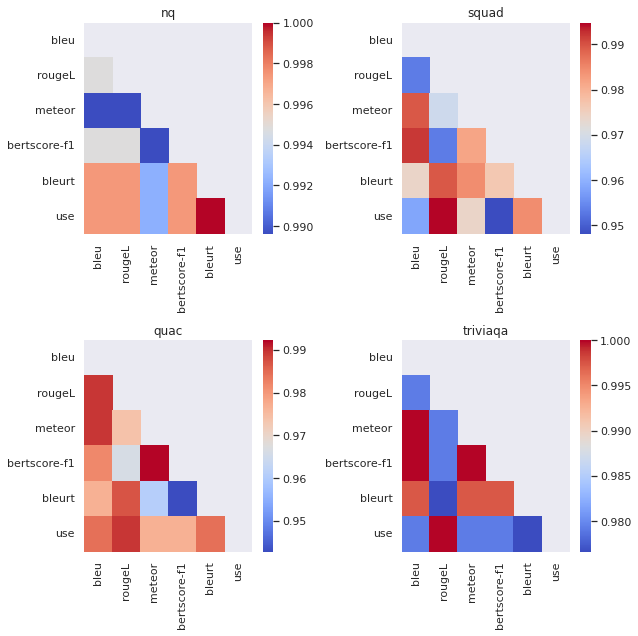

In [129]:
fig, axes = plt.subplots(2, 2, figsize=(9, 9))

for ax, dataset in zip(axes.flat, datasets):
    sns.heatmap(similarity[dataset], mask=mask, cmap="coolwarm", ax=ax).set(
        title=dataset
    )

fig.tight_layout()

plt.show()

### Black

In [130]:
!pip install black[jupyter]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 5.0 MB/s 
     |████████████████████████████████| 843 kB 40.7 MB/s 
     |████████████████████████████████| 96 kB 5.0 MB/s 
     |████████████████████████████████| 1.6 MB 32.0 MB/s 
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [131]:
!black "/content/drive/MyDrive/Colab Notebooks/rr_evaluation_sandbox.ipynb"

reformatted /content/drive/MyDrive/Colab Notebooks/rr_evaluation_sandbox.ipynb

All done! ✨ 🍰 ✨
1 file reformatted.
